In [17]:
'''
Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
Dataset : https://data.mendeley.com/datasets/rscbjbr9sj/2
By Thomas Sabatier
'''

'\nIdentifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning\nDataset : https://data.mendeley.com/datasets/rscbjbr9sj/2\nBy Thomas Sabatier\n'

## Data exploration and preprocessing

In [46]:

# Librairies

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [19]:

# Loading datasets

data_path = './data/chest_xray/'
batch_size = 32
img_height = 224
img_width = 224

# Build datasets with 32 batches and shuffle
train_data = image_dataset_from_directory(
    directory=data_path+'train',
    validation_split=0.2,
    subset='training',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True,
    seed=42)

val_data = image_dataset_from_directory(
    directory=data_path+'train',
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True,
    seed=42)

test_data = image_dataset_from_directory(
    directory=data_path+'test',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True,
    seed=42)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [20]:

# Size of image and label batches
for image_batch, labels_batch in test_data.take(1):
    print("Image batch shape", image_batch.shape)
    print("Label batch shape", labels_batch.shape)
    
# Exploring class balance
class_names = train_data.class_names

class_counts = {class_name: 0 for class_name in train_data.class_names}
for images, labels in train_data:
    for label in labels.numpy():
        class_name = train_data.class_names[label]
        class_counts[class_name] += 1
        
total_samples = sum(class_counts.values())
class_percentages = {k: (v / total_samples) * 100 for k, v in class_counts.items()}
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts.values())}

print(f"Class counts: {class_counts}")
print(f"Class percentages: {class_percentages}")

# Check RGB channel value
image_batch, labels_batch = next(iter(train_data)) # select first batch
first_image = image_batch[0]
print('RGB value:',np.min(first_image), np.max(first_image))


Image batch shape (32, 224, 224, 3)
Label batch shape (32,)
Class counts: {'NORMAL': 1092, 'PNEUMONIA': 3081}
Class percentages: {'NORMAL': 26.168224299065418, 'PNEUMONIA': 73.83177570093457}
RGB value: 0.0 255.0


In [21]:

'''
There is a limited amount of data. So we'll perform data augmentation to reduce overfitting.
The classes are imbalanced. Therefore, we'll set up custom weights during model training.
RGB values are represented on a scale of 0 to 255 pixels. 
So we'll apply RGB channel pre-processing depending on the chosen CNN model.
'''

"\nThere is a limited amount of data. So we'll perform data augmentation to reduce overfitting.\nThe classes are imbalanced. Therefore, we'll set up custom weights during model training.\nRGB values are represented on a scale of 0 to 255 pixels. \nSo we'll apply RGB channel pre-processing depending on the chosen CNN model.\n"

In [22]:

# Data Augmentation
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3))),
data_augmentation.add(layers.RandomRotation(0.1)),
data_augmentation.add(layers.RandomZoom(0.2)),
data_augmentation.add(layers.RandomBrightness(0.2))
                      

In [23]:

def display_xray_sample(data, batch_number=1, display_range=9, augmented_images=None, data_augmentation=data_augmentation):
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(batch_number):
        for i in range(display_range):
            if augmented_images == True:
                images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(data.class_names[labels[i]])
            plt.axis("off")


In [32]:

def plot_history(history, callback):

    epochs_range = range(callback.stopped_epoch+1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['acc'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    

In [35]:

def print_performances(history):
    print(f"Mean accuracy on training data : {np.mean(history.history['acc'])}")
    print(f"Mean accuracy on validation data : {np.mean(history.history['val_acc'])}")
    print(f"Mean loss on training data : {np.mean(history.history['loss'])}")
    print(f"Mean loss on validation data : {np.mean(history.history['val_loss'])}")


In [41]:

def display_confusion_matrix(model, test_data):
    y_pred = model.predict(test_data)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat([y for x, y in test_data], axis=0)
    display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted']))
    

In [48]:

def determine_class(data/_path=data_path):
    folder_normal = data_path+'val/NORMAL/'
    folder_pneumonia = data_path+'val/PNEUMONIA/'
    folder = random.choice([folder_normal, folder_pneumonia])
    
    img = random.choice(os.listdir(folder))
    img = load_img(img, target_size=(224, 224))
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
    )


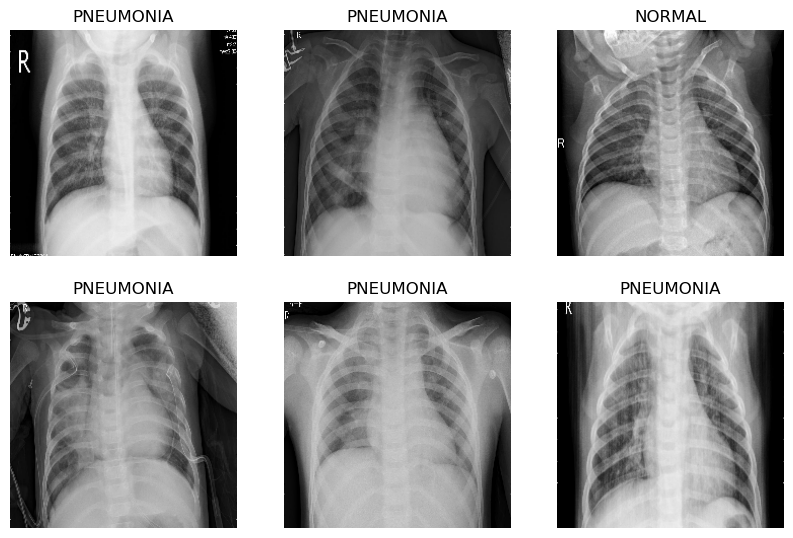

In [27]:

# Display the n first x-rays of a selected batch (1st one in this example)
display_xray_sample(train_data, display_range=6)
        

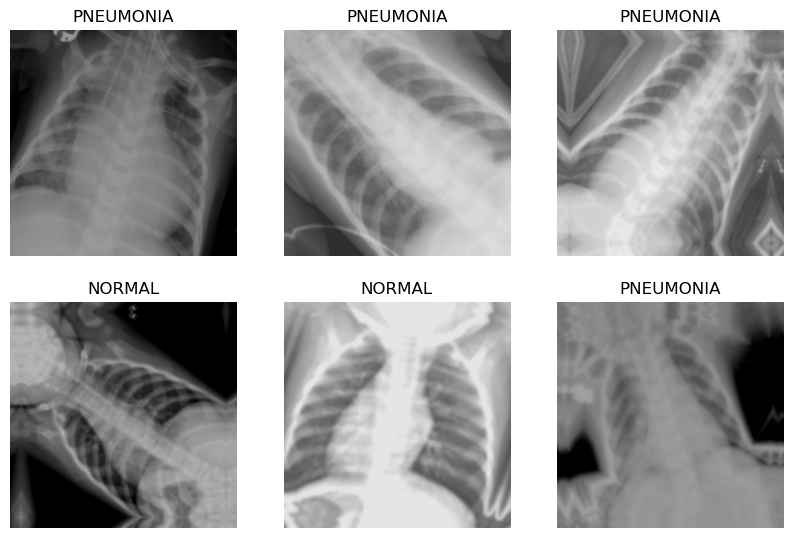

In [28]:

# Display data augmentation on x-ray
display_xray_sample(train_data, augmented_images=True, display_range=6)


## Regular CNN model

In [29]:

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten()) # Flatten 3D filters
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['acc'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [30]:

epochs = 10
callback = callbacks.EarlyStopping(monitor='val_loss', 
                                   patience=3, 
                                   verbose=1, 
                                   restore_best_weights=True)

# Fit the model with augmented data and weighted classes
history = model.fit(train_data,
                   epochs=epochs,
                   validation_data=val_data,
                   class_weight=class_weights,
                   callbacks=[callback])


Epoch 1/10
131/131 [==============================] - 172s 1s/step - loss: 0.7090 - acc: 0.6125 - val_loss: 0.3973 - val_acc: 0.8360
Epoch 2/10
131/131 [==============================] - 182s 1s/step - loss: 0.4287 - acc: 0.8088 - val_loss: 0.4657 - val_acc: 0.7958
Epoch 3/10
131/131 [==============================] - 187s 1s/step - loss: 0.3345 - acc: 0.8586 - val_loss: 0.3148 - val_acc: 0.8926
Epoch 4/10
131/131 [==============================] - 180s 1s/step - loss: 0.3287 - acc: 0.8682 - val_loss: 0.3138 - val_acc: 0.8926
Epoch 5/10
131/131 [==============================] - 197s 1s/step - loss: 0.2971 - acc: 0.8840 - val_loss: 0.3516 - val_acc: 0.8686
Epoch 6/10
131/131 [==============================] - 188s 1s/step - loss: 0.2875 - acc: 0.8843 - val_loss: 0.3214 - val_acc: 0.8648
Epoch 7/10
131/131 [==============================] - 148s 1s/step - loss: 0.2679 - acc: 0.8905 - val_loss: 0.1956 - val_acc: 0.9319
Epoch 8/10
131/131 [==============================] - 147s 1s/step - 

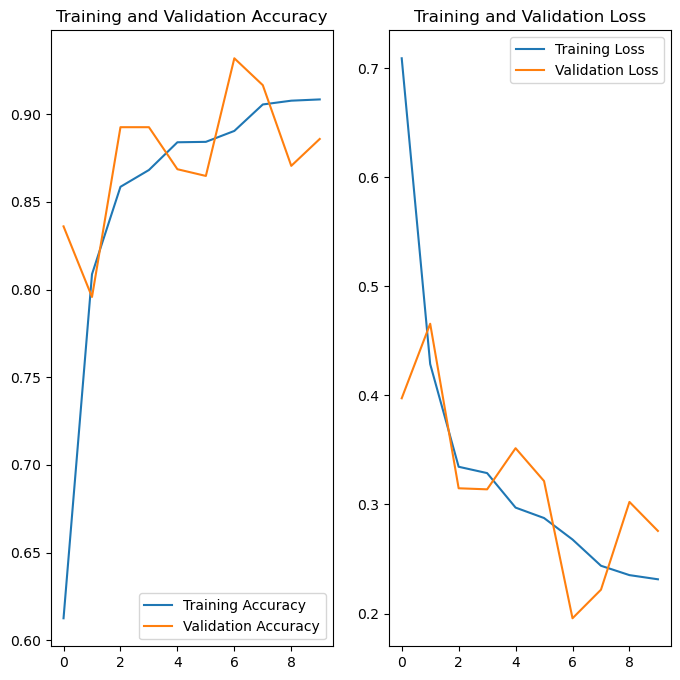

Mean accuracy on training data : 0.8528636515140533
Mean accuracy on validation data : 0.875551289319992
Mean loss on training data : 0.33639332056045534
Mean loss on validation data : 0.3160210832953453
20/20 [==============================] - 6s 258ms/step


Predicted    0    1
True               
0           59  175
1          128  262

In [43]:
plot_history(history, callback)
print_performances(history)
display_confusion_matrix(model, test_data)

In [ ]:
'''
In conclusion, although the model showed good results during training, 
it did not perform well on the test data, indicating an overfitting issue. 
Therefore, we can improve the model by implementing transfer learning 
using existing and already trained CNN models.
'''

## VGG16 model

In [44]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG16 weights
for layer in base_model.layers: 
    layer.trainable = False
    
modelVGG16 = models.Sequential()
modelVGG16.add(data_augmentation)
modelVGG16.add(layers.Lambda(preprocess_input))
modelVGG16.add(base_model) # Ajout du mod√®le VGG16
modelVGG16.add(layers.Flatten()) 
modelVGG16.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dropout(0.4))
modelVGG16.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.4))
modelVGG16.add(layers.Dense(2, activation='softmax'))

modelVGG16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

epochs = 10
callback_vgg16 = callbacks.EarlyStopping(monitor='val_loss', 
                                   patience=5, 
                                   verbose=1, 
                                   restore_best_weights=True)

historyVGG16 = modelVGG16.fit(train_data,
                   epochs=epochs,
                   validation_data=val_data,
                   class_weight=class_weights,
                   callbacks=[callback_vgg16])
      

Epoch 1/10
131/131 [==============================] - 785s 6s/step - loss: 10.0494 - acc: 0.8780 - val_loss: 0.7608 - val_acc: 0.8360
Epoch 2/10
131/131 [==============================] - 802s 6s/step - loss: 0.2729 - acc: 0.9286 - val_loss: 0.3542 - val_acc: 0.9281
Epoch 3/10
131/131 [==============================] - 769s 6s/step - loss: 0.2002 - acc: 0.9473 - val_loss: 0.1701 - val_acc: 0.9444
Epoch 4/10
131/131 [==============================] - 779s 6s/step - loss: 0.1506 - acc: 0.9514 - val_loss: 0.1018 - val_acc: 0.9645
Epoch 5/10
131/131 [==============================] - 781s 6s/step - loss: 0.1164 - acc: 0.9595 - val_loss: 0.0924 - val_acc: 0.9684
Epoch 6/10
131/131 [==============================] - 810s 6s/step - loss: 0.0976 - acc: 0.9643 - val_loss: 0.1283 - val_acc: 0.9645
Epoch 7/10
131/131 [==============================] - 793s 6s/step - loss: 0.0887 - acc: 0.9645 - val_loss: 0.1391 - val_acc: 0.9578
Epoch 8/10
131/131 [==============================] - 801s 6s/step -

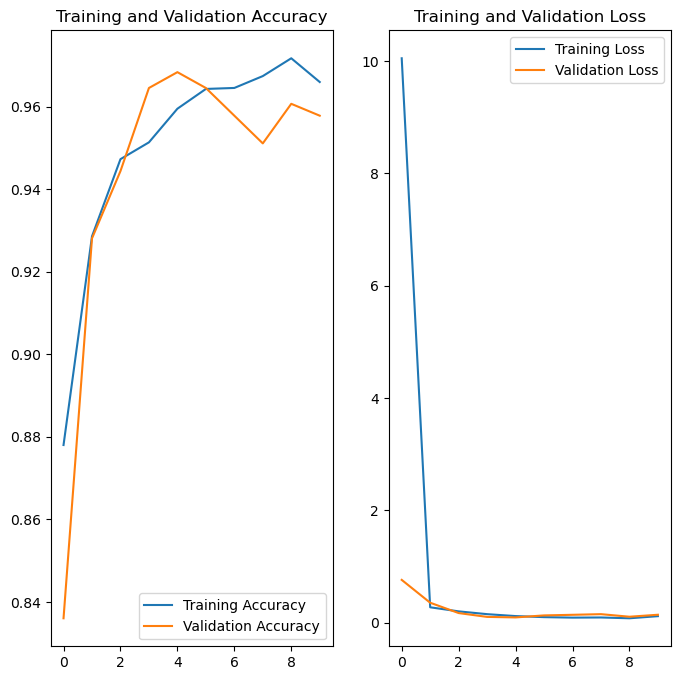

Mean accuracy on training data : 0.9498682022094727
Mean accuracy on validation data : 0.9433365285396575
Mean loss on training data : 1.1259209133684636
Mean loss on validation data : 0.21419663354754448
20/20 [==============================] - 81s 4s/step


Predicted   0    1
True              
0          47  187
1          91  299

In [45]:

plot_history(historyVGG16, callback_vgg16)
print_performances(historyVGG16)
display_confusion_matrix(modelVGG16, test_data)


In [ ]:
determine_class()